In [1]:
import os
from argparse import Namespace
from PIL import Image
import torch

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from model import Generator
from dataset import inverse_normalize

In [2]:
config = Namespace(
    batch_size = 128,
    num_workers = 3,
    input_chanels = 3,
    noise_dim = 100,
    lr=0.0002,
    beta1=0.5,
    beta2 = 0.999,
    num_epochs = 30,
    folder_path_celeba='/kaggle/input/celebahq-resized-256x256/celeba_hq_256',
    folder_path_weights='weights',
    folder_path_gen_images='generated_images',
)

# Load model and generate

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator(noise_dim=config.noise_dim, input_chanels=3).to(device)
state_dict = torch.load(f'{config.folder_path_weights}/g_model_epoch_49.pt', map_location=torch.device(device))
G.load_state_dict(state_dict=state_dict)
G.eval()

Generator(
  (upsample_layer1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer5): Sequential(
    (

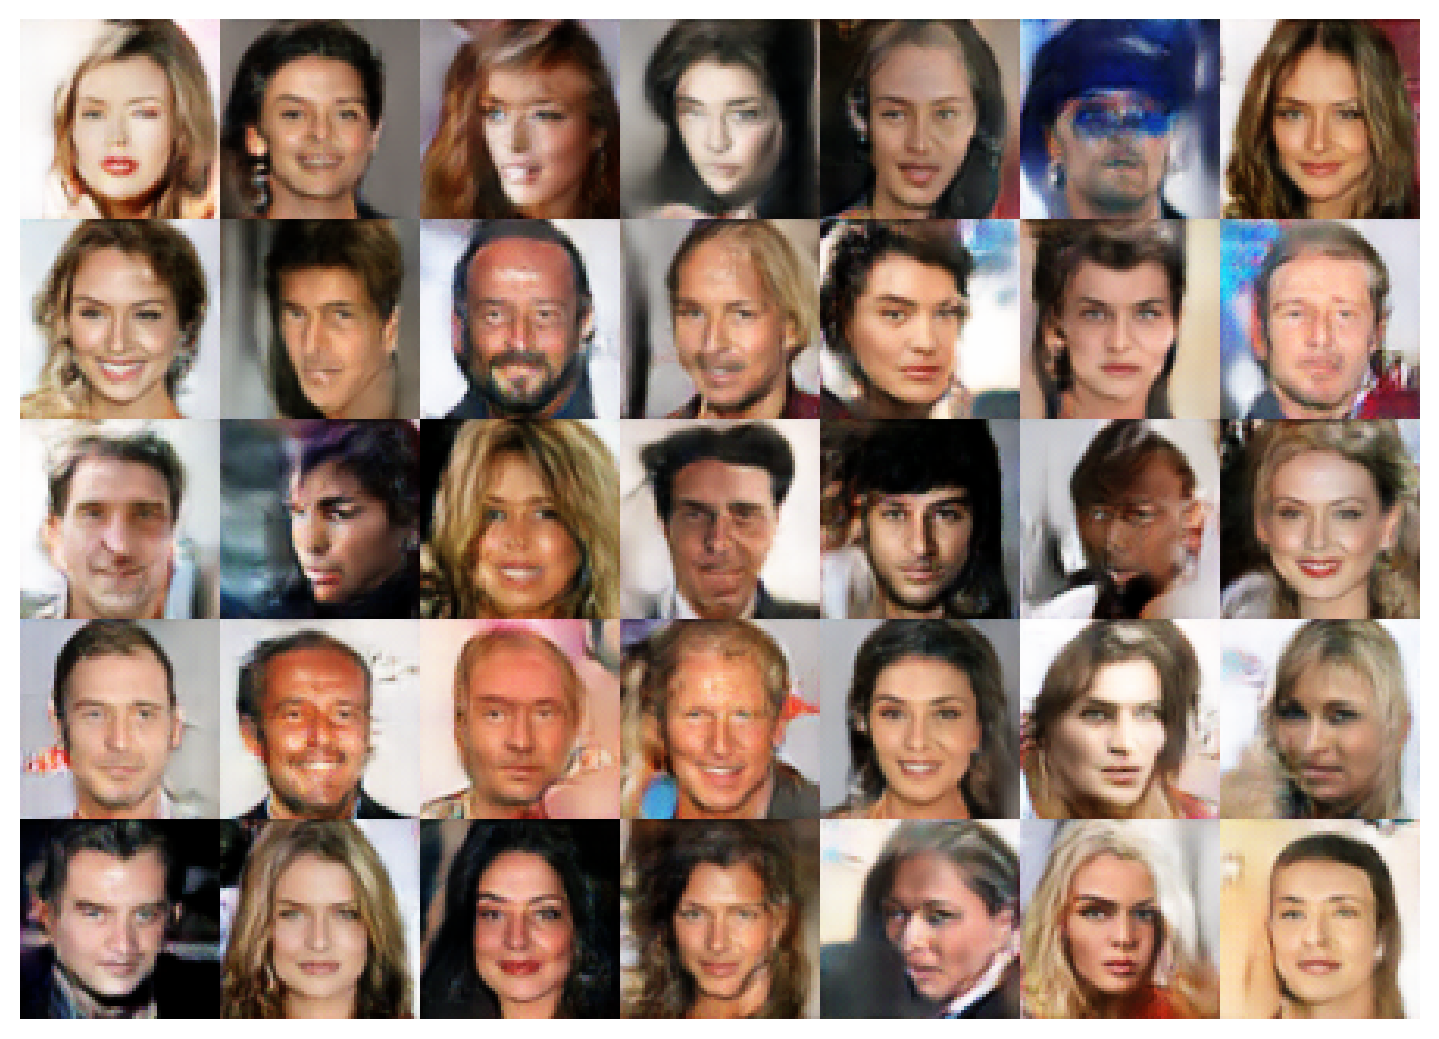

In [21]:
noise = torch.randn(35, config.noise_dim, 1, 1).to(device)
fake_imgs = G(noise).detach().cpu()

fig, axs = plt.subplots(5, 7, figsize=(7,5))
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
axs = axs.flatten()
for i in range(35):
    axs[i].imshow(inverse_normalize(fake_imgs[i]).permute(1,2,0))
    axs[i].axis('off')
plt.show()

# Create animation

In [18]:
img_filenames = os.listdir(config.folder_path_gen_images)
img_filenames = sorted(img_filenames)

generated = []
for img_filename in img_filenames[10::3]: # skip the first 10 and jump over 3
    img_path = os.path.join(config.folder_path_gen_images, img_filename)
    img = Image.open(img_path)
    generated.append(img)

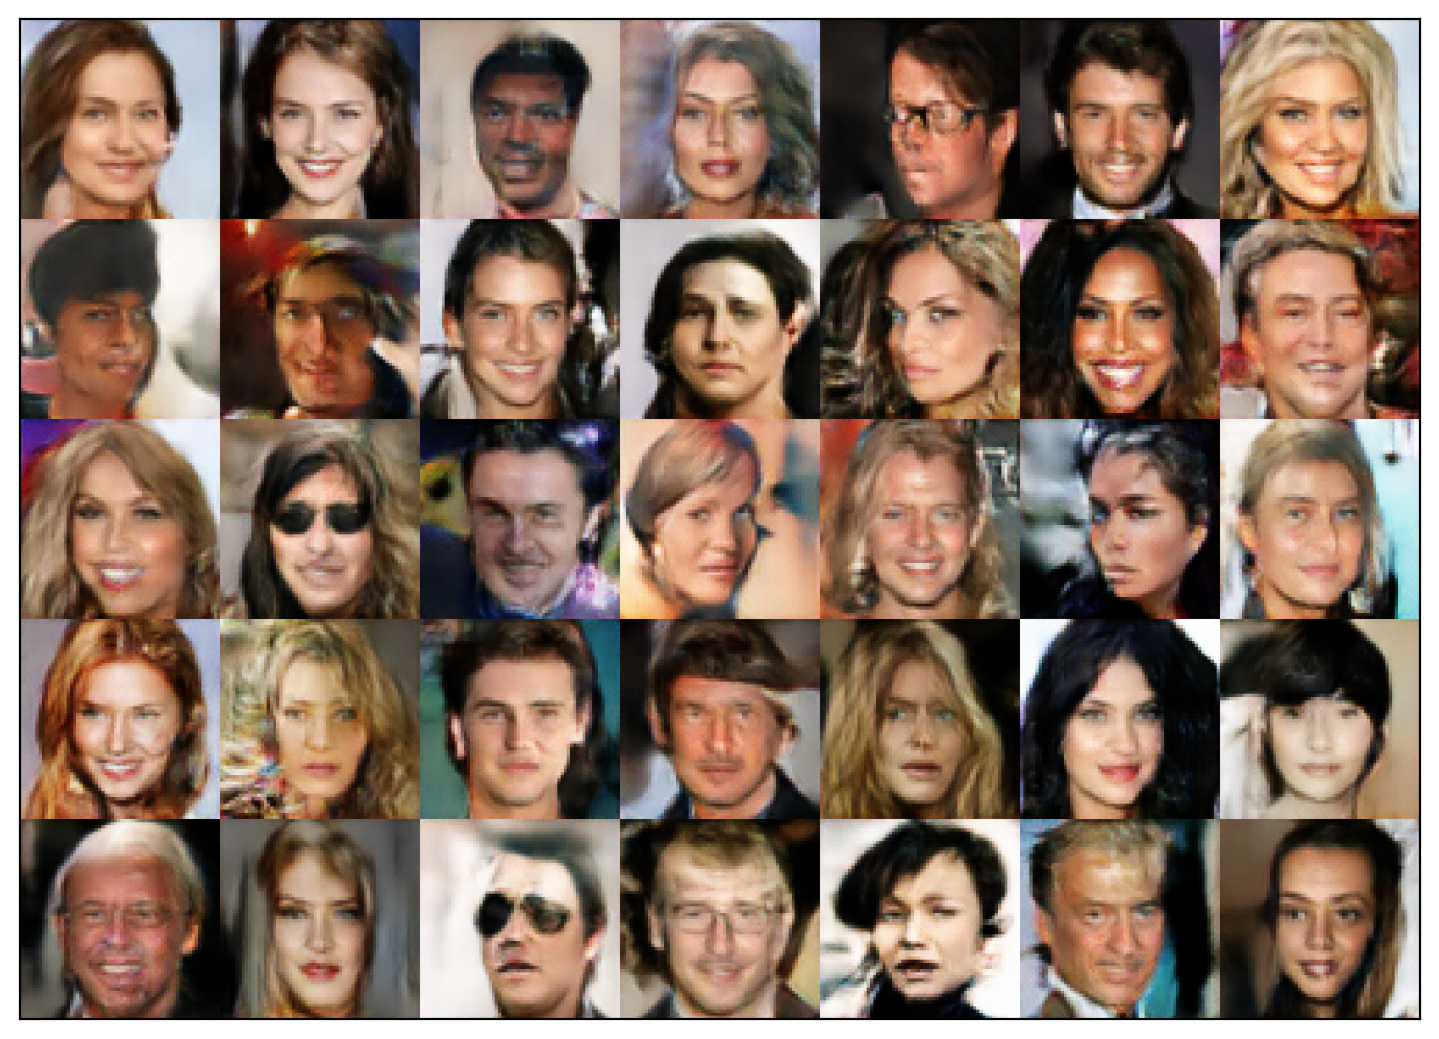

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

def animate(i):
    ax.clear()
    f = ax.imshow(generated[i])
    ax.set_xticks([])
    ax.set_yticks([])
    return f

ani = FuncAnimation(fig=fig, func=animate, repeat=True, frames=len(generated))
ani.save("animation_celeba.gif", dpi=100, writer=PillowWriter(fps=1.1))
plt.show()